# Running Exercise 3: Solving the Anastasia Romanov mystery
#### Ayala, J.; Vizitiu, M.; Öncel, P.
#### Lund University, BINP16: Programming in Python (Created on: 27-10-2020)

## Introduction

We are a team of researchers at Lund University, studying the genetic evidence regarding the House of Romanov, the reigning imperial house of Russia from 1613 to 1917, until the time when all members of the family were executed during the uprising of the Bolshevik revolution. The bodies of the Romanovs and their close relatives were discovered some ten years later by an amateur archaeologist. DNA evidence was collected from each one, as well as several other people who are involved in this sordid tale.

We are tasked with analyzing all of the DNA evidence, and derive a conclusion about Anastasia Romanov, the youngest daughter of Tsar Nicholas II. Whether Anastasia Romanov is still alive, and if so, whether she is one of the women claiming to be her, or the discovered remains of Anastasia is actually the deceased princess herself.


## Methodology

### Part I: Calculate all sequence combinations identity and raw scores.

We began our analysis by looking at the collected DNA samples and performing multiple sequence alignments. We received two sets of DNA data to work with: (1) mtdna_orig.fasta: sequences of mitochondrial DNA that were used to establish maternal relationship between the samples, and (2) y_chromosome_orig.fasta: sequences of Y chromosome that were used to establish paternal relationship between the samples.

First, we include the necessary modules and relative paths

In [1]:
import os
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

base_path = os.getcwd() + '/'

weights_file = os.path.join(base_path, "data/weights.txt")
mtdna_fasta = os.path.join(base_path, "data/mtdna_orig.fasta")
ychr_fasta = os.path.join(base_path, "data/y_chromosome_orig.fasta")
mtdna_scores_file = os.path.join(base_path, "results/MSAmtdna.txt")
ychr_scores_file = os.path.join(base_path, "results/MSAYchr.txt")
mtdna_id_matrix_file = os.path.join(base_path, "results/output_id_mtdna.txt")
ychr_id_matrix_file = os.path.join(base_path, "results/output_id_ychr.txt")
mtdna_score_matrix_file = os.path.join(base_path, "results/output_score_mtdna.txt")
ychr_score_matrix_file = os.path.join(base_path, "results/output_score_ychr.txt")

In [2]:
mtdna_contents = ''
with open(mtdna_fasta, 'r') as mtdna_file:
    mtdna_contents = mtdna_file.read()
ychr_contents = ''
with open(ychr_fasta, 'r') as ychr_file:
    ychr_contents = ychr_file.read()

We started by looking at the DNA samples in a pairwise fashion, calculating the identity and alignment scores for each aligned pair. At this step, our script contained two user-defined functions: (1)  score_alignment_identity(): a function that calculates the identity and alignment scores for a given pair of sequences (2) fasta_to_dict(): a function that converts a fasta file into a dictionary where the sequence IDs are stored as keys and the sequences are stored as values. The identity and alignment scores for each of the sequence pairs in the dictionary were written out two output files: (1) MSAmtdna.txt: containing the scores for the mitochondrial DNA samples  (2) MSAYchr.txt: containing the scores for the Y chromosomal samples.


In [3]:
def fasta_to_dict(fasta_file):
    '''
    this is a function to convert a fasta file into a dictionary
    Arguments : fasta_file : file with fasta sequences, where the header delimiter is a tab
    Returns : dictionary with sequence IDs as keys, and sequences as values
    '''
    sequences = {} # set up an empty dictionary to store sequence ID and sequence

    # how to retrieve sequences from the fasta file
    with open(fasta_file, 'r') as fasta:
        for line in fasta:
            if line.startswith('>'): # get ID and sequence and add to dictionary
                header = line.strip()[1:]
                sequences[header] = next(fasta).upper().strip()
    return sequences

In [4]:
def score_alignment_identity(seq_1, seq_2, weights):
    '''
    this is a function to score an alignment of a pair of sequences
    Arguments :  seq_1, seq_2 (str) : two aligned sequences including gaps
                 weights (dict) : scores for reference
    Returns : identity and alignment scores (tuple)
    '''
    nucleotides = ['A', 'T', 'G', 'C', '?', '-']      # list of all nucleotides
    purines = ['A', 'G']                              # list of purine nucleotides
    pyrimidines = ['T', 'C']                          # list of pyrimidine nucleotides

    score = 0                                         # variable to store score
    identical = 0                                     # variable to store identical nucleotides

    # how to calculate pairwise alignment score
    for i in range(len(seq_1)):
        if (seq_1[i] == seq_2[i]):                    # when they are same
            if (seq_1[i] == '-' or seq_1[i] == '?'):  # when they are gaps
                pass
            else:                                     # when its a match
                score += weights['match']
                identical += 1
        elif (seq_1[i] in purines and seq_2[i] in purines) or (seq_1[i] in pyrimidines and seq_2[i] in pyrimidines):
            score += weights['transition']            # when its a transition
        elif (seq_1[i] == '-' or seq_2[i] == '-'):    # when theres a gap
            score += weights['gap']
        elif (seq_1[i] == '?' or seq_2[i] == '?'):    # when one is unknown
            pass
        else:                                         # when its a transversion
            score += weights['transversion']
    # how to calculate pairwise identity score
    identity = round(100 * identical / len(seq_1), 1) # divide nr of identical by length
    return identity, score                            # return score and identity as a tuple

In [5]:
# Dictionary for weights file
weights = {}  # set up an empty dictionary to store weight type and value
with open(weights_file, 'r') as weight_file: # Open a weights file and
    for line in weight_file:
        line = line.split()
        weights[line[0]] = int(line[1]) # add weight type and values to dictionary
print(weights)

{'match': 1, 'transition': -1, 'transversion': -2, 'gap': -1}


In [6]:
# Converting fasta files to dictionaries
fasta_dict_mtdna = fasta_to_dict(mtdna_fasta)
fasta_dict_ychr = fasta_to_dict(ychr_fasta)

#### Calculating scores
Once both files are in a dictionary format, the identity and scores are calculated for all pairs of sequences, and written to a file.

In [7]:
# mtDNA file
with open(mtdna_scores_file, 'w') as output_file:
    output_file.write('SmpA\tSmpB\tId_s\tAl_s\n')               # write out header row
    for i, (key_1, seq_1) in enumerate(fasta_dict_mtdna.items()):     # get ID and seq from dictionary
        for j, (key_2, seq_2) in enumerate(fasta_dict_mtdna.items()): # get ID and seq from dictionary
            if i < j:                                           # compare two non-repeating sequences
                iden, score_seq = score_alignment_identity(seq_1, seq_2, weights) # get identity and alignment scores
                output_file.write('{}\t{}\t{}%\t{}\n'.format(key_1, key_2, iden, score_seq)) # write out data
# Y chromosome file
with open(ychr_scores_file, 'w') as output_file:
    output_file.write('SmpA\tSmpB\tId_s\tAl_s\n')               # write out header row
    for i, (key_1, seq_1) in enumerate(fasta_dict_ychr.items()):     # get ID and seq from dictionary
        for j, (key_2, seq_2) in enumerate(fasta_dict_ychr.items()): # get ID and seq from dictionary
            if i < j:                                           # compare two non-repeating sequences
                iden, score_seq = score_alignment_identity(seq_1, seq_2, weights) # get identity and alignment scores
                output_file.write('{}\t{}\t{}%\t{}\n'.format(key_1, key_2, iden, score_seq)) # write out data

### Part 2: Generating similarity matrices

The second part of our analysis consists of building similarity matrices based on pairwise alignment scores and percentages of identity between all of the DNA sequences involved. These scores were obtained during the first part of the analysis and stored in two .txt files: MSAmtdna.txt and MSAYchr.txt, containing the results for the alignment of the mtDNA fragments and the Y chromosome fragments respectively.

We designed a Python script capable of using the previously mentioned input files in order to write files containing scoring matrices for both the alignment scores and the identity percentages.  The identity percentages are kept as they are in the matrices as a result of the fact that they range between 0- 100% and are easy to interpret. The alignment scores were normalized and converted to values ranging from 0 to 100, where 100 is the normalized score for the highest scoring alignment of sequences. 

This part of the analysis consisted of the following steps:

1. Defining a function that converts the data in the input file (i. e. scores and percentages of identity of pairwise sequence alignments) into similarity matrices in the form of nested dictionaries. The keys of the main dictionary consist of the IDs of all of the DNA sequences analyzed. Nested dictionaries are assigned as values to these keys and contain the IDs of the sequences being compared to the key of the main dictionary, as well as the scores of the comparisons.
The main dictionary is redundant, in the sense that it contains each pairwise alignment twice, but this was done in order to generate a full matrix, where all of the sequence IDs are present both in the header row, as well as in the first column of the matrix.
2. Inside this same function, the alignment scores are normalized in order for the resulting matrices to become easier to interpret. The way this conversion is achieved is by adding the absolute value of the lowest alignment score to all of the scores (the lowest score now becomes equal to 0) and then dividing all scores by the highest value. By multiplying all normalized scores by 100, this generates a range of alignment scores from 0 to 100, where 100 is assigned to the highest scoring sequences. The diagonal of the matrix (i. e. where sequences are compared against themselves) is scored arbitrarily with 100.


In [8]:
def msa_to_dict(input_file):    #Function that stores data from the input file into a nested dictionary
    msa_matrix_identity = {}    #Matrix (dictionary of dictionaries) of identity percentages
    msa_matrix_score = {}       #Matrix (dictionary of dictionaries) of alignment scores
    list_of_scores = []         #List of all the alignment scores
    with open(input_file, 'r') as msa_file: #Read the input file
        header = next(msa_file) #Read the header (we do not need the information in the header)
        for line in msa_file:   #Read every line in the input file
            line = line.rstrip().split('\t') # Split the line by its columns and remove new line character
            if line[0] not in msa_matrix_identity: # If the ID does not exist in the dictionary
                msa_matrix_identity[line[0]] = {line[0]: '100'} #Add it with an identity percentage of 100 (when sequence is compared against itself)
                msa_matrix_score[line[0]] = {line[0]: '-'} #Add it without a score ("-") (when compared against itself)
#We add the IDs in the second column of each line to the same dictionary so that the output will be a full, symmetrical matrix. The steps are identical to the ones above
            if line[1] not in msa_matrix_identity: 
                msa_matrix_identity[line[1]] = {line[1]: '100'}
                msa_matrix_score[line[1]] = {line[1]: '-'}
# The identity percentages and the alignment scores are then added to the corresponding dictionaries of dictionaries as values in the nested dictionaries
            msa_matrix_identity[line[0]][line[1]] = line[2].replace('%', '')
            msa_matrix_identity[line[1]][line[0]] = line[2].replace('%', '')
            msa_matrix_score[line[0]][line[1]] = line[3]
            msa_matrix_score[line[1]][line[0]] = line[3]
            list_of_scores.append(int(line[3])) #Add the alignment scores to a list
#Normalizing the values of the alignment scores to add them to the matrix
    min_val = min(list_of_scores)   #Find the smallest alignment score
    max_val = max(list_of_scores)   #Find the largest alignment score
    for key1 in msa_matrix_score:   #Iterate through all the sequence IDs
        for key2 in msa_matrix_score[key1]: #Iterate through all the nested dictionaries
            if msa_matrix_score[key1][key2] != '-': #If a sequence is not compared with itself
                current_value = float(msa_matrix_score[key1][key2]) #Normalize the score value...
                msa_matrix_score[key1][key2] = round(100*(current_value + abs(min_val))/(max_val + abs(min_val)), 1)    #...by adding the absolute value of the smallest score to all scores and then dividing by the largest value. The result is multiplied by 100 to be easier to read as a percentage
            else:   #When the sequence is compared with itself
                msa_matrix_score[key1][key2] = 100  #Set the alignment score to 100
    return msa_matrix_identity, msa_matrix_score

3. Another function was defined, that prints the resulting matrices to separate output files (one for normalized scores and one for percentage of identity), in the desired format. The sequence IDs and the values in the matrix are tab separated; two matrices are generated for every input file. A third function was created to get the most similar sequence to a specific name (Though it's not used in this report)

In [9]:
def make_matrix_file(msa_matrix, output_file):
#Function that writes the matrices to the output files
    with open(output_file, 'w') as output_matrix:   #Open the output file for writing
        header = sorted(msa_matrix.keys())  #The first line consists of all the sequence IDs (sorted)
        header_str = '\t' + '\t'.join(header)   #Separate the IDs by tab in the header
        output_matrix.write(header_str + '\n')  #Write the header to the output file
        for key1 in sorted(msa_matrix.keys()):  #Iterate through all the sorted sequence IDs
            output_matrix.write(key1)           #Write one ID at a time to the output file
            for key2 in sorted(msa_matrix[key1]):
                output_matrix.write('\t' + str(msa_matrix[key1][key2])) #Followed by all of the alignment scores between that ID and the other ones, separated by tab
            output_matrix.write('\n')           #Add a new line

In [10]:
def get_most_similar(msa_dict, name):           #Function for finding the most similar sequence to a specific sequence
    max_value = 0                               #Variable that stores the value of the largest alignment score
    max_key = ''                                #Variable that stores the sequence ID corresponding to the largest alignment score
    for key in msa_dict[name].keys():           #Iterate through all the sequence IDs
        if key != name:                         #Exclude the case of a sequence being compared with itself
            if float(msa_dict[name][key]) > max_value:  #If an alignment score is larger than the current largest one being stored in the variable
                max_value = float(msa_dict[name][key])  #Store the new score as the largest
                max_key = key                   #Store the corresponding sequence ID
    return max_key, max_value

4. For the purpose of our analysis, all functions are called twice, once for the mtDNA alignments, and once for the Y chromosome alignments, resulting in four total scoring matrices.

In [11]:
identity_mtdna, score_mtdna = msa_to_dict(mtdna_scores_file)  #Calling the function for the input file; two matrices are returned
identity_ychr, score_ychr = msa_to_dict(ychr_scores_file)

In [12]:
make_matrix_file(identity_mtdna, mtdna_id_matrix_file)         #Write the percentage identity matrix to one output file by calling the proper function
make_matrix_file(score_mtdna, mtdna_score_matrix_file)            #Write the normalized score matrix to another output file by calling the proper function
make_matrix_file(identity_ychr, ychr_id_matrix_file)
make_matrix_file(score_ychr, ychr_score_matrix_file)

### Part 3: Building the hierarchical clusters and dendograms

Once we created the similarity matrix, we built  hierarchical clusters using the linkage function from  the scipy.cluster.hierarchy module. This function performs agglomerative clustering given a 2d array of observations. In this case, each vector would be the list of normalized or identity scores. A function would parse the matrix file, separating the data from the labels (i.e. the sequence ids), and then apply the linkage function. We used default settings for the linkage function, using the ‘single’ method (Nearest point algorithm) and euclidean metric. Our function receives a path, and returns the labels and the clustering arrays.

In [13]:
def create_clusters(input_file, cluster_method = 'single'):
    '''
    Function to create a hierarchical cluster, given a matrix file. Returns an
    array with the relationships between sequences.
    Arguments:
        input_file: Similarity matrix in a tab delimited file.
        cluster_method: Method used for the linkage function.
    Returns:
        clusters: Array with the scores of relationships among sequences.
        labels: List of labels of the matrix file.
    '''
    #Initializing variables for the parsing of the file.
    data = []
    labels = []
    with open(input_file, 'r') as matrix_file:
        header = next(matrix_file)
        for line in matrix_file:
            line = line.strip().split()
            labels.append(line[0])  # first column is added to the labels
            row = []
            for i in range(1, len(line)):
                row.append(float(line[i]))  #The rest of columns are converted to float and added to the data
            data.append(row)
    # The linkage function is used to create the hierarchical cluster of the given data.
    clusters = linkage(data, method = cluster_method)
    return clusters, labels

Then, this function is called 4 times, for the identity and normalized scores of the mtDNA and Y chromosomes respectively

In [14]:
# Build the clusters for all 4 matrix files
clusters_id_ychr, labels_id_ychr = create_clusters(ychr_id_matrix_file, 'single')
clusters_score_ychr, labels_score_ychr = create_clusters(ychr_score_matrix_file, 'single')
clusters_id_mtdna, labels_id_mtdna = create_clusters(mtdna_id_matrix_file, 'single')
clusters_score_mtdna, labels_score_mtdna = create_clusters(mtdna_score_matrix_file, 'single')

Finally, we plotted the clusters for each case using the dendrogram function. In the original script, all dendrograms are added as subplots of one figure. However, this report includes them as individual plots for readability purposes. 

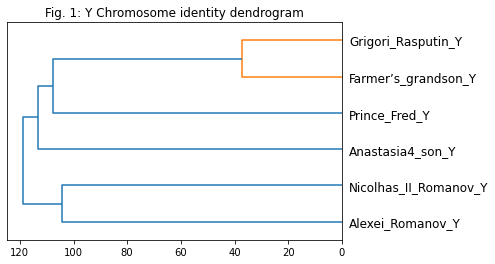

In [15]:
# Create dendogram for the Y Chromosome identity matrix
plt.title('Fig. 1: Y Chromosome identity dendrogram')
dendrogram(clusters_id_ychr
           , labels = labels_id_ychr
           , orientation = 'left') # Setting orientation of the labels/tree

plt.show() # Plotting the figure

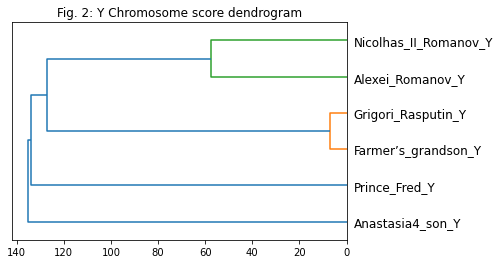

In [16]:
# Create dendogram for the Y Chromosome scoring matrix
plt.title('Fig. 2: Y Chromosome score dendrogram')
dendrogram(clusters_score_ychr
           , labels = labels_score_ychr
           , orientation = 'left')
plt.show()

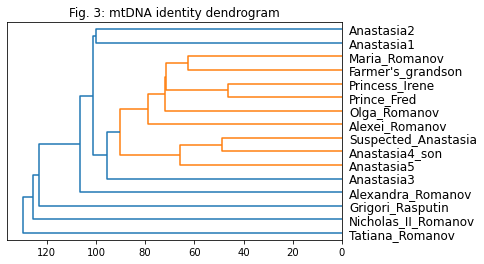

In [17]:
# Create dendogram for the mtDNA identity matrix
plt.title('Fig. 3: mtDNA identity dendrogram')
dendrogram(clusters_id_mtdna
            , labels = labels_id_mtdna
            , orientation = 'left')
plt.show()

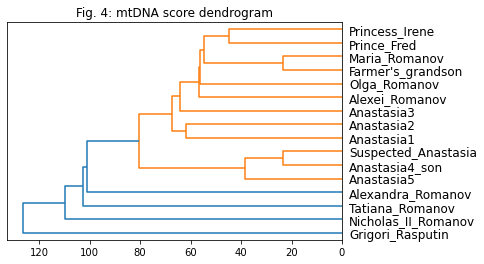

In [18]:
# Create dendogram for the mtDNA scoring matrix
plt.title('Fig. 4: mtDNA score dendrogram')
dendrogram(clusters_score_mtdna
            , labels = labels_score_mtdna
            , orientation = 'left')
plt.show()

## Analysis

The analysis of the Y chromosome sequences reveals that the farmer’s grandson is very closely related paternally to Grigori Rasputin, the two sequences having an identity percentage of 75% and being by far the most similar sequences in the Y chromosome analysis. The testimonies take note of the grandson’s and Rasputin’s close physical resemblance. Moreover, the farmer’s daughter appears to be extremely distressed when Rasputin’s name is mentioned. Therefore, we conclude that Grigori Rasputin is in fact the father of the farmer’s grandson.


In [19]:
get_most_similar(identity_ychr, "Farmer’s_grandson_Y")

('Grigori_Rasputin_Y', 75.0)

The analysis of the mitochondrial DNA alignments and the corresponding dendrogram showed a strong degree of similarity between Anastasia 4’s son and the suspected body of Anastasia Romanov, as shown in fig. 3 and 4. Provided that the real Anastasia Romanov is still alive, the suspected body does not belong to her. More research needs to be done, but our results tend to suggest that Anastasia 4 planted evidence that would be closely related to her son (perhaps even her own DNA, in which case her reticence to provide a DNA sample can be explained) to bias the analysis towards proving that she is the real Anastasia Romanov.


In [20]:
get_most_similar(identity_mtdna, "Anastasia4_son")

('Suspected_Anastasia', 69.2)

It is also worth noting that the resulting dendrograms contain multiple false positive and negative results. For instance, Nicholas II Romanov and his son, Alexei, appear to not be closely related based on the Y chromosome analysis. It is extremely likely that this is the case because of the poor quality of some of the DNA sequences.

In [21]:
print('Nicholas_II_Romanov\n', fasta_dict_mtdna['Nicholas_II_Romanov'])
print('Alexei_Romanov\n', fasta_dict_mtdna['Alexei_Romanov'])

Nicholas_II_Romanov
 -----GGGG-----AAA---------
Alexei_Romanov
 ACC???AGCTAGCT----TAGCTTTT


The highlight of our analysis is represented by our conclusions regarding the fate of the real Anastasia Romanov. Our mtDNA dendrograms reveal the positioning of the farmer’s grandson in the same cluster as members of the royal family (fig. 3 and fig. 4). Most notably, the farmer’s grandson is closely related to good quality mtDNA samples (i.e. those of Princess Irene and Prince Fred); due to the poor quality of the samples prelevated from the deceased royal family members, false positive and false negative results are common. Considering that the farmer’s grandson is maternally related to the royal family, we infer that his mother, the farmer’s daughter, is related to the royal family as well. Moreover, our overall conclusion, based on the data that was available to us, is that the farmer’s daughter is in fact the real Anastasia Romanov.

To answer the question of what happened to the real Anastasia, the farmer’s testimony reveals that each member of the royal family was shot once in order to be executed. However, one shot is not guaranteed to be fatal and Anastasia was harmed, but not killed. The farmer admits to having been paid to dispose of the bodies, and, because Anastasia was still alive, he took her in and raised her in secret as his own daughter.
One challenge that we encountered in formulating our conclusion is the mismatch of the farmer’s daughter age and physical characteristics to those of the supposed real Anastasia Romanov. The farmer’s daughter is 36, older than the real Anastasia is believed to be. Moreover the eye and hair color do not match. These issues were addressed in a plausible manner by Anastasia 5, who mentioned that an explanation for a different age is a mistake in the birth certificate; she also explains the difference in eye and hair color as an aesthetic choice of the painters of the royal family portraits. As a result, we conclude that the farmer’s daughter is the most plausible candidate to be the real Anastasia Romanov.
